# Split quasar according to redshift
More importantly, reweight them after the splitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100
from astropy.io import fits
import healpy as hp
import seaborn as sns
from imsys_fitter import Syst
from sklearn.neighbors import BallTree

In [2]:
maps = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
random_all = np.hstack((random_n, random_s))
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
quasar_all = np.hstack((quasar_n, quasar_s))
# quasar_SDSS = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
# tree = BallTree(data=np.deg2rad(np.c_[quasar_SDSS['DEC'], quasar_SDSS['RA']]),
#                     leaf_size=5, metric='haversine')

In [7]:
# =====================================
# === copyed from reweighting.ipynb ===
# =====================================
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

Rg = 3.793                                      # from 2002AJ....123..485S table 22

def get_property_map(ra, dec):
    pix = hp.ang2pix(Nside, np.deg2rad(90 - dec), np.deg2rad(ra))
    data = {}
    data['EBV'] = maps['EBV'][pix]
    data['DEPTH_G'] = 22.5 - 2.5*np.log10(maps['DEPTH_G'][pix]) - Rg*data['EBV']
    data['SKY_I'] = maps['SKY_I'][pix]
    data['PSF_I'] = maps['PSF_I'][pix]
    return data

def reweight(quasar_cata, random_cata):
    data_q = get_property_map(quasar_cata['RA'], quasar_cata['DEC'])
    data_r = get_property_map(random_cata['RA'], random_cata['DEC'])

    analyzer = Syst(quasar_cata['WEIGHT_FKP']*quasar_cata['WEIGHT_CP']*quasar_cata['WEIGHT_NOZ'], random_cata['WEIGHT_FKP'])
    for k in data_q.keys():
        analyzer.add_syst(k, data_q[k], data_r[k])
    analyzer.cut_outliers(p=1)
    analyzer.prepare()
    analyzer.fit_minuit()
    result = dict(zip(analyzer.par_names, analyzer.best_pars))
    weight_model = 1/analyzer.get_model(result, data_q)
    return weight_model

def refine_catalogue(quasar):
    quasar_cata = np.zeros(len(quasar), dtype=[('ra', 'f8'), ('dec', 'f8'), ('z', 'f8'), ('w', 'f8')])
    quasar_cata['ra'] = quasar['RA']
    quasar_cata['dec'] = quasar['DEC']
    quasar_cata['z'] = quasar['Z']
    quasar_cata['w'] = quasar['WEIGHT_SYSTOT']*quasar['WEIGHT_NOZ']*quasar['WEIGHT_CP']*quasar['WEIGHT_FKP']
    return quasar_cata

scale: 6.870972823634812 arcmin


Question: seperate luminosity from all quasars or from N/SGC? reweight the quasar from N/GC

Now I use quasar_n to split into two samples according to luminosity (quasar_n_high_L, quasar_n_low_L), reweight them and put them together to construct quasar_high_L, quasar_low_L. 

In [4]:
z_edge = np.quantile(quasar_all['Z'], [0, 1/3, 2/3, 1])

In [5]:
def split_redshift_and_reweight(quasar, random, z_edge):
    """
    split the catalogue and reweight it seperately.
    """
    result = np.digitize(quasar['Z'], z_edge)

    quasars = []
    for i in range(1, len(z_edge)):
        qu = quasar[result == i]
        qu['WEIGHT_SYSTOT'] = reweight(qu, random)
        quasars.append(refine_catalogue(qu))
    
    return quasars

In [8]:
quasar_n_split = split_redshift_and_reweight(quasar_n, random_n, z_edge)
quasar_s_split = split_redshift_and_reweight(quasar_s, random_s, z_edge)

(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 225.36   ndata = 40                rchi2 = 5.6341
chi2 (after  fit) = 61.42   ndata = 40   npars = 5   rchi2 = 1.7549
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 258.70   ndata = 40                rchi2 = 6.4674
chi2 (after  fit) = 48.13   ndata = 40   npars = 5   rchi2 = 1.3752
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 240.74   ndata = 40                rchi2 = 6.0184
chi2 (after  fit) = 32.69   ndata = 40   npars = 5   rchi2 = 0.9341
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) 

In [14]:
random_origin = np.load('../catalogue/random_quasar_lss_all.npy')

for i in range(1, len(z_edge)):
    quasar_save = np.hstack((quasar_n_split[i-1], quasar_s_split[i-1]))
    random_save = random_origin.copy()
    random_save['z'] = np.random.choice(quasar_save['z'], len(random_save))
    np.save(f'../catalogue/quasar_lss_z{i}', quasar_save)
    np.save(f'../catalogue/random_z{i}.npy', random_save)

## testing part

In [18]:
def split_redshift_and_reweight_test(quasar, random, z_edge):
    """
    split the catalogue and reweight it seperately. for testing
    """
    result = np.digitize(quasar['Z'], z_edge)

    quasars = []
    weights = []
    for i in range(1, len(z_edge)):
        qu = quasar[result == i]
        weights.append(reweight(qu, random))
        quasars.append(qu)
    
    return quasars, weights

In [19]:
q, w = split_redshift_and_reweight_test(quasar_n, random_n, z_edge)

(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 225.36   ndata = 40                rchi2 = 5.6341
chi2 (after  fit) = 61.42   ndata = 40   npars = 5   rchi2 = 1.7549
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 258.70   ndata = 40                rchi2 = 6.4674
chi2 (after  fit) = 48.13   ndata = 40   npars = 5   rchi2 = 1.3752
(0.0, 0, 0, 0, 0)
Maps available for chi2:
['EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
Fitting for:
['constant', 'EBV', 'DEPTH_G', 'SKY_I', 'PSF_I']
chi2 (before fit) = 240.74   ndata = 40                rchi2 = 6.0184
chi2 (after  fit) = 32.69   ndata = 40   npars = 5   rchi2 = 0.9341


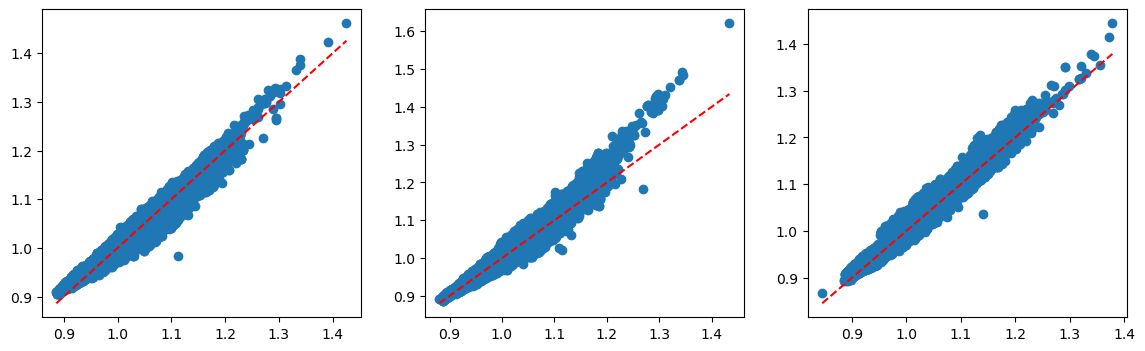

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i in range(len(axes)):
    wq = q[i]['WEIGHT_SYSTOT']
    wr = w[i]
    axes[i].scatter(wq, wr)
    axes[i].plot((wq.min(), wq.max()), (wq.min(), wq.max()), 'r--')